使用到的套件們

In [1]:
import numpy as np 
import pandas as pd 
import datetime
from pylab import rcParams
import matplotlib.pyplot as plt
import warnings
import itertools
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler
import os

### (a) Pick one raw material and collect its dataset.
這邊選用Henry Hub Natural Gas Spot Price，原始資料為1997/01/10至今的周資料，本次分析中僅採用2000年至今的周資料
讀檔，並令日期為price('WHHNGSP')的index，取日期為2000/01/01以後的資料

In [2]:
df = pd.read_csv("WHHNGSP.csv",parse_dates=['DATE'])
df = df.sort_values('DATE')
df = df.groupby('DATE')['WHHNGSP'].sum().reset_index()
df.set_index('DATE', inplace=True)
df = df.loc[datetime.date(year=2000,month=1,day=1):]

#處理中發現第300筆資料missing，設其為0
df['WHHNGSP'].iloc[299]=0

df = df.astype('float64')

確認資料的index和起始日期正確

In [3]:
df.index

DatetimeIndex(['2000-01-07', '2000-01-14', '2000-01-21', '2000-01-28',
               '2000-02-04', '2000-02-11', '2000-02-18', '2000-02-25',
               '2000-03-03', '2000-03-10',
               ...
               '2020-09-18', '2020-09-25', '2020-10-02', '2020-10-09',
               '2020-10-16', '2020-10-23', '2020-10-30', '2020-11-06',
               '2020-11-13', '2020-11-20'],
              dtype='datetime64[ns]', name='DATE', length=1090, freq=None)

確認價格是否有missing value

In [4]:
df['WHHNGSP'].isna().sum()

0

繪出price根據時間變化的對應值

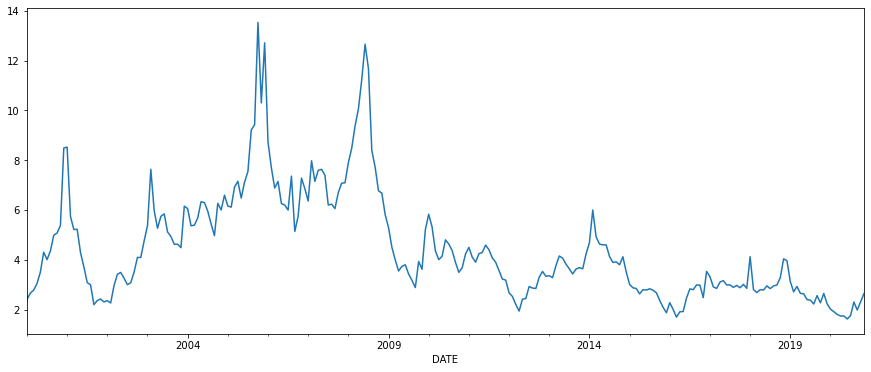

In [5]:
y = df['WHHNGSP'].resample('MS').mean()
y.plot(figsize=(15, 6))
plt.show()

### (b) Prepare and transform the data to appropriate format
將資料標準化為後續跑模型做準備

In [6]:
sc = MinMaxScaler(feature_range = (0, 1))
df = sc.fit_transform(df)

將資料分成train data(前70%)和test data(後30%)

In [7]:
train_size = int(len(df) * 0.70)
test_size = len(df) - train_size
train, test = df[0:train_size, :], df[train_size:len(df), :]

連結前後期之值，令後期之值為前期的結果，並調整資料的形式令其符合LSTM的shape

In [8]:
def create_data_set(_data_set, _look_back=1):
    data_x, data_y = [], []
    for i in range(len(_data_set) - _look_back - 1):
        a = _data_set[i:(i + _look_back), 0]
        data_x.append(a)
        data_y.append(_data_set[i + _look_back, 0])
    return np.array(data_x), np.array(data_y)

In [9]:
look_back =90
X_train,Y_train,X_test,Ytest = [],[],[],[]
X_train,Y_train = create_data_set(train,look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test,Y_test=create_data_set(test,look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### (b) Build LSTM model and show the prediction results via Time series Nested Cross Validation 
以train 資料訓練 Sequential()中的LSTM模型，

In [10]:
# create and fit the LSTM network regressor = Sequential() 
regressor = Sequential()

regressor.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 60))
regressor.add(Dropout(0.1))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)
history =regressor.fit(X_train, Y_train, epochs = 20, batch_size = 15,validation_data=(X_test, Y_test), callbacks=[reduce_lr],shuffle=False)

Epoch 1/20
45/45 [==============================] - 10s 220ms/step - loss: 0.0164 - val_loss: 0.0011
Epoch 2/20
45/45 [==============================] - 7s 162ms/step - loss: 0.0116 - val_loss: 0.0011
Epoch 3/20
45/45 [==============================] - 7s 153ms/step - loss: 0.0117 - val_loss: 0.0012
Epoch 4/20
45/45 [==============================] - 7s 157ms/step - loss: 0.0117 - val_loss: 0.0013
Epoch 5/20
45/45 [==============================] - 7s 151ms/step - loss: 0.0113 - val_loss: 0.0012
Epoch 6/20
45/45 [==============================] - 7s 149ms/step - loss: 0.0117 - val_loss: 0.0011
Epoch 7/20
45/45 [==============================] - 7s 160ms/step - loss: 0.0236 - val_loss: 0.0083
Epoch 8/20
45/45 [==============================] - 7s 160ms/step - loss: 0.0118 - val_loss: 0.0096
Epoch 9/20
45/45 [==============================] - 7s 148ms/step - loss: 0.0100 - val_loss: 0.0065
Epoch 10/20
45/45 [==============================] - 7s 154ms/step - loss: 0.0091 - val_loss: 0.004

利用訓練好的模型，預測test 資料，並將預期的結果逆標準化，以轉成原始的值

In [11]:
train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)

train_predict = sc.inverse_transform(train_predict)
Y_train = sc.inverse_transform([Y_train])
test_predict = sc.inverse_transform(test_predict)
Y_test = sc.inverse_transform([Y_test])

繪出，train, test 的error隨著epochs的變化

Train Mean Absolute Error: 0.7692757224752789
Train Root Mean Squared Error: 1.1138102310840918
Test Mean Absolute Error: 0.5856907562078055
Test Root Mean Squared Error: 0.6653584306786463


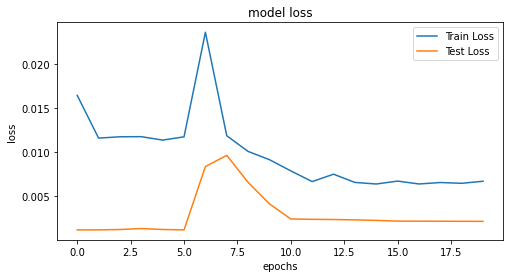

In [12]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

### (c) Visualize the time rolling prediction as above diagram.
繪出實際和預測值隨時間的變化

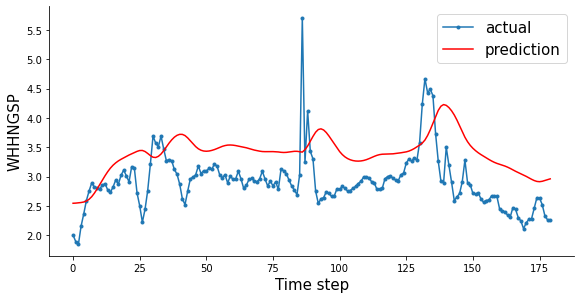

In [13]:
#Compare Actual vs. Prediction
aa=[x for x in range(180)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:180], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:180], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('WHHNGSP', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();